# Adaptive SVD Background Subtraction

This algorithm describes a background subtraction method using **adaptive SVD** (Singular Value Decomposition).


## Overview

The algorithm processes frames from a **static camera** and uses an **initialization matrix** $A \in \mathbb{R}^{m \times n}$ to build a background model. It outputs background and foreground masks for each input frame.


## Initialization

1. Compute the initial SVD components from $A$:
   $$
   A \approx U \Sigma V^\top
   $$
   where:
   - $U \in \mathbb{R}^{m \times r}$: Left singular vectors  
   - $\Sigma \in \mathbb{R}^{r \times r}$: Diagonal matrix of singular values  
   - $V^\top \in \mathbb{R}^{r \times n}$: Right singular vectors  
   - $r$: Initial rank (chosen based on $\tau^*$)


## Per-Frame Processing

For each new frame $B \in \mathbb{R}^{m \times 1}$:

1. **Read**, **vectorize**, and **normalize** the image $B$.
2. **Project $B$ onto the background subspace** using:
   $$
   J = UU^\top B
   $$
3. Compute the **foreground mask** $F$:
   $$
   F = |B - J| > \theta
   $$
   where $\theta$ is a foreground detection threshold.
4. Append $B$ as a column to the matrix $M$:
   $$
   M = [M \,|\, B]
   $$


## Batch Update (Every $\beta$ Frames)

When $M$ accumulates $\beta$ columns:

1. **Update SVD** using `SVDAppend`:
   $$
   [U, \Sigma, V] \leftarrow \texttt{SVDAppend}(U, \Sigma, V, M)
   $$
2. **Reset** $M \leftarrow \emptyset$.


## Reinitialization

If the number of columns in $U$ exceeds the threshold $n^*$:

- **Recompute SVD** using a new matrix $A$ with `SVDComp`:
  $$
  [U, \Sigma, V] \leftarrow \texttt{SVDComp}(A, \tau^*)
  $$


## Parameters

| Symbol        | Meaning                                             |
|---------------|-----------------------------------------------------|
| $\tau^*$      | Target rank used in `SVDComp`                       |
| $\varepsilon$ | Max Frobenius norm relative to mean image norm     |
| $\tau$        | Threshold for singular values in `SVDAppend`       |
| $\theta$      | Threshold for foreground detection                  |
| $\beta$       | Block size: number of frames before update         |
| $n^*$         | Max allowed size of $U$ (columns) before reinit     |


## Summary

This **adaptive SVD** framework evolves the background model over time while maintaining efficiency via:

- **`SVDAppend`**: Fast SVD updates using new frames.
- **`SVDComp`**: Reinitialization when the model grows too large.
- **Threshold-based masking**: Accurate foreground detection via:
  $$
  F = |B - UU^\top B| > \theta
  $$

It’s suitable for real-time background subtraction with a balance of **speed**, **adaptability**, and **accuracy**.


In [ ]:
!pip install -r requirements.txt

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob

def svd_comp(A, tau):
    # Compute SVD
    U, s, Vh = np.linalg.svd(A, full_matrices=False)
    
    # Determine rank using tau parameter
    total_energy = np.sum(s**2)
    energy_threshold = tau * total_energy
    cumulative_energy = np.cumsum(s**2)
    i = np.searchsorted(cumulative_energy, energy_threshold) + 1
    
    # Return truncated SVD components
    return U[:, :i], np.diag(s[:i]), i

def svd_append(U, Sigma, M, tau):
    # Calculate orthogonal component of M with respect to U
    Y = M - U @ (U.T @ M)
    
    # QR decomposition of Y
    Q, R = np.linalg.qr(Y, mode='reduced')
    
    # Create augmented matrix
    K = np.block([
        [Sigma, U.T @ M],
        [np.zeros((R.shape[0], Sigma.shape[1])), R]
    ])
    
    # SVD of K
    Uk, sk, Vhk = np.linalg.svd(K, full_matrices=False)
    
    # Determine new rank using slope of singular values
    diffs = np.diff(sk)
    i_new = np.argmax(diffs < tau * sk[:-1]) + 1
    
    # Update U and Sigma
    U_new = np.hstack([U, Q]) @ Uk[:, :i_new]
    Sigma_new = np.diag(sk[:i_new])
    
    return U_new, Sigma_new, i_new

def process_image_sequence(image_folder, pattern="*.jpg", init_frames=50, tau_star=0.95, 
                          tau=0.01, theta=0.05, beta=10, n_star=100, max_frames=None):

    # Get list of all image files in the folder matching the pattern
    image_files = sorted(glob.glob(os.path.join(image_folder, pattern)))
    
    if len(image_files) == 0:
        raise ValueError(f"No images found in {image_folder} with pattern {pattern}")
    
    print(f"Found {len(image_files)} images")
    
    # Adjust init_frames if needed
    init_frames = min(init_frames, len(image_files))
    
    # Read first image to get dimensions
    first_img = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
    height, width = first_img.shape
    
    # Initialize matrix A with initialization frames
    print(f"Reading {init_frames} initialization frames...")
    A = np.zeros((height * width, init_frames))
    
    for i in range(init_frames):
        img = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
        # Ensure all images have the same dimensions
        if img.shape != (height, width):
            img = cv2.resize(img, (width, height))
        # Normalize pixel values to [0,1]
        normalized = img.astype(float) / 255.0
        A[:, i] = normalized.flatten()
    
    # Compute initial SVD components
    print("Computing initial SVD components...")
    U, Sigma, i = svd_comp(A, tau_star)
    print(f"Initial SVD has {i} components")
    
    # Initialize M for batch processing
    M = np.zeros((height * width, 0))
    
    # Determine the number of frames to process
    total_frames = len(image_files)
    if max_frames is not None:
        total_frames = min(total_frames, max_frames)
    
    # Create dictionary to store results for all frames
    results = {}
    
    # Process all frames
    print("Processing image frames...")
    for frame_count in tqdm(range(total_frames)):
        # Read frame
        img = cv2.imread(image_files[frame_count], cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Could not read image {image_files[frame_count]}")
            continue
            
        # Ensure correct dimensions
        if img.shape != (height, width):
            img = cv2.resize(img, (width, height))
        
        # Normalize
        B = img.astype(float) / 255.0
        B_vec = B.flatten()
        
        # Project B onto current background model
        J = U @ (U.T @ B_vec)
        
        # Compute foreground mask
        diff = np.abs(B_vec - J)
        F = np.zeros_like(B_vec)
        F[diff > theta] = 1
        F_reshaped = F.reshape(height, width)
        
        # Reshape background
        background = J.reshape(height, width)
        
        # Store frame data for all frames
        results[frame_count] = {
            'original': B.copy(),
            'background': background.copy(),
            'foreground': F_reshaped.copy(),
            'rank': U.shape[1]
        }
        
        # Append to block M
        M = np.column_stack([M, B_vec])
        
        # If block is full, update SVD
        if M.shape[1] == beta:
            U, Sigma, i = svd_append(U, Sigma, M, tau)
            M = np.zeros((height * width, 0))
            print(f"Updated SVD model at frame {frame_count}, new rank: {i}")
        
        # Check if we need reinitialization
        if U.shape[1] > n_star:
            print(f"Reinitializing SVD at frame {frame_count}...")
            # Create new matrix from U*Sigma
            A_new = U @ Sigma
            U, Sigma, i = svd_comp(A_new, tau_star)
            print(f"Reinitialized rank: {i}")
    
    print(f"Processing complete. Processed {total_frames} frames.")
    return results

def display_results_grid(results, figsize=(20, 15), dpi=100):
    """
    Display results in a grid layout
    
    Args:
        results: Dictionary with frame results
        figsize: Figure size (default: (20, 15))
        dpi: DPI for figure (default: 100)
    """
    # Sort frames by index
    frame_indices = sorted(results.keys())
    n_frames = len(frame_indices)
    
    # For large numbers of frames, select a sample
    if n_frames > 30:
        print(f"Too many frames ({n_frames}) to display all. Selecting a sample...")
        selected_indices = np.linspace(0, n_frames-1, 30, dtype=int)
        frame_indices = [frame_indices[i] for i in selected_indices]
        n_frames = len(frame_indices)
    
    # Adjust figure size based on number of frames
    adjusted_figsize = (figsize[0], max(15, n_frames*1.5))
    
    # Create figure
    fig, axes = plt.subplots(n_frames, 3, figsize=adjusted_figsize, dpi=dpi)
    
    # If only one frame, make axes 2D
    if n_frames == 1:
        axes = axes.reshape(1, -1)
    
    for i, frame_idx in enumerate(frame_indices):
        frame_data = results[frame_idx]
        
        # Plot original
        axes[i, 0].imshow(frame_data['original'], cmap='gray')
        axes[i, 0].set_title(f"Frame {frame_idx}: Original")
        axes[i, 0].axis('off')
        
        # Plot background
        axes[i, 1].imshow(frame_data['background'], cmap='gray')
        axes[i, 1].set_title(f"Frame {frame_idx}: Background")
        axes[i, 1].axis('off')
        
        # Plot foreground
        axes[i, 2].imshow(frame_data['foreground'], cmap='gray')
        axes[i, 2].set_title(f"Frame {frame_idx}: Foreground")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

Found 800 images
Reading 100 initialization frames...
Computing initial SVD components...
Initial SVD has 1 components
Processing image frames...


  4%|▎         | 28/800 [00:00<00:02, 279.69it/s]

Updated SVD model at frame 9, new rank: 1
Updated SVD model at frame 19, new rank: 1
Updated SVD model at frame 29, new rank: 1
Updated SVD model at frame 39, new rank: 1
Updated SVD model at frame 49, new rank: 1


  7%|▋         | 58/800 [00:00<00:02, 287.44it/s]

Updated SVD model at frame 59, new rank: 1


 11%|█         | 87/800 [00:00<00:03, 215.97it/s]

Updated SVD model at frame 69, new rank: 1
Updated SVD model at frame 79, new rank: 1
Updated SVD model at frame 89, new rank: 1
Updated SVD model at frame 99, new rank: 1


 18%|█▊        | 140/800 [00:00<00:03, 218.50it/s]

Updated SVD model at frame 109, new rank: 1
Updated SVD model at frame 119, new rank: 1
Updated SVD model at frame 129, new rank: 1
Updated SVD model at frame 139, new rank: 1
Updated SVD model at frame 149, new rank: 1


 24%|██▍       | 193/800 [00:00<00:02, 233.92it/s]

Updated SVD model at frame 159, new rank: 1
Updated SVD model at frame 169, new rank: 1
Updated SVD model at frame 179, new rank: 1
Updated SVD model at frame 189, new rank: 1
Updated SVD model at frame 199, new rank: 1
Updated SVD model at frame 209, new rank: 1


 31%|███       | 247/800 [00:01<00:02, 236.86it/s]

Updated SVD model at frame 219, new rank: 1
Updated SVD model at frame 229, new rank: 1
Updated SVD model at frame 239, new rank: 1
Updated SVD model at frame 249, new rank: 1
Updated SVD model at frame 259, new rank: 1


 38%|███▊      | 300/800 [00:01<00:02, 235.96it/s]

Updated SVD model at frame 269, new rank: 1
Updated SVD model at frame 279, new rank: 1
Updated SVD model at frame 289, new rank: 1
Updated SVD model at frame 299, new rank: 1
Updated SVD model at frame 309, new rank: 1


 44%|████▍     | 353/800 [00:01<00:01, 245.55it/s]

Updated SVD model at frame 319, new rank: 1
Updated SVD model at frame 329, new rank: 1
Updated SVD model at frame 339, new rank: 1
Updated SVD model at frame 349, new rank: 1
Updated SVD model at frame 359, new rank: 1
Updated SVD model at frame 369, new rank: 1


 50%|█████     | 403/800 [00:01<00:01, 234.13it/s]

Updated SVD model at frame 379, new rank: 1
Updated SVD model at frame 389, new rank: 1
Updated SVD model at frame 399, new rank: 1
Updated SVD model at frame 409, new rank: 1
Updated SVD model at frame 419, new rank: 1


 54%|█████▍    | 430/800 [00:01<00:01, 240.10it/s]

Updated SVD model at frame 429, new rank: 1


 57%|█████▊    | 460/800 [00:01<00:01, 249.80it/s]

Updated SVD model at frame 439, new rank: 1
Updated SVD model at frame 449, new rank: 1
Updated SVD model at frame 459, new rank: 1
Updated SVD model at frame 469, new rank: 1
Updated SVD model at frame 479, new rank: 1


 61%|██████▏   | 490/800 [00:02<00:01, 263.70it/s]

Updated SVD model at frame 489, new rank: 1


 65%|██████▌   | 520/800 [00:02<00:01, 267.34it/s]

Updated SVD model at frame 499, new rank: 1
Updated SVD model at frame 509, new rank: 1
Updated SVD model at frame 519, new rank: 1
Updated SVD model at frame 529, new rank: 1


 68%|██████▊   | 547/800 [00:02<00:00, 257.28it/s]

Updated SVD model at frame 539, new rank: 1


 72%|███████▏  | 573/800 [00:02<00:00, 256.71it/s]

Updated SVD model at frame 549, new rank: 1
Updated SVD model at frame 559, new rank: 1
Updated SVD model at frame 569, new rank: 1
Updated SVD model at frame 579, new rank: 1
Updated SVD model at frame 589, new rank: 1


 75%|███████▌  | 600/800 [00:02<00:00, 256.59it/s]

Updated SVD model at frame 599, new rank: 1


 79%|███████▉  | 630/800 [00:02<00:00, 265.24it/s]

Updated SVD model at frame 609, new rank: 1
Updated SVD model at frame 619, new rank: 1
Updated SVD model at frame 629, new rank: 1
Updated SVD model at frame 639, new rank: 1
Updated SVD model at frame 649, new rank: 1


 82%|████████▎ | 660/800 [00:02<00:00, 265.99it/s]

Updated SVD model at frame 659, new rank: 1


 86%|████████▋ | 690/800 [00:02<00:00, 267.98it/s]

Updated SVD model at frame 669, new rank: 1
Updated SVD model at frame 679, new rank: 1
Updated SVD model at frame 689, new rank: 1
Updated SVD model at frame 699, new rank: 1
Updated SVD model at frame 709, new rank: 1


 90%|█████████ | 720/800 [00:02<00:00, 253.09it/s]

Updated SVD model at frame 719, new rank: 1


 93%|█████████▎| 746/800 [00:03<00:00, 232.32it/s]

Updated SVD model at frame 729, new rank: 1
Updated SVD model at frame 739, new rank: 1
Updated SVD model at frame 749, new rank: 1


 96%|█████████▋| 770/800 [00:03<00:00, 233.33it/s]

Updated SVD model at frame 759, new rank: 1
Updated SVD model at frame 769, new rank: 1
Updated SVD model at frame 779, new rank: 1


100%|██████████| 800/800 [00:03<00:00, 245.11it/s]


Updated SVD model at frame 789, new rank: 1
Updated SVD model at frame 799, new rank: 1
Processing complete. Processed 800 frames.
Too many frames (800) to display all. Selecting a sample...


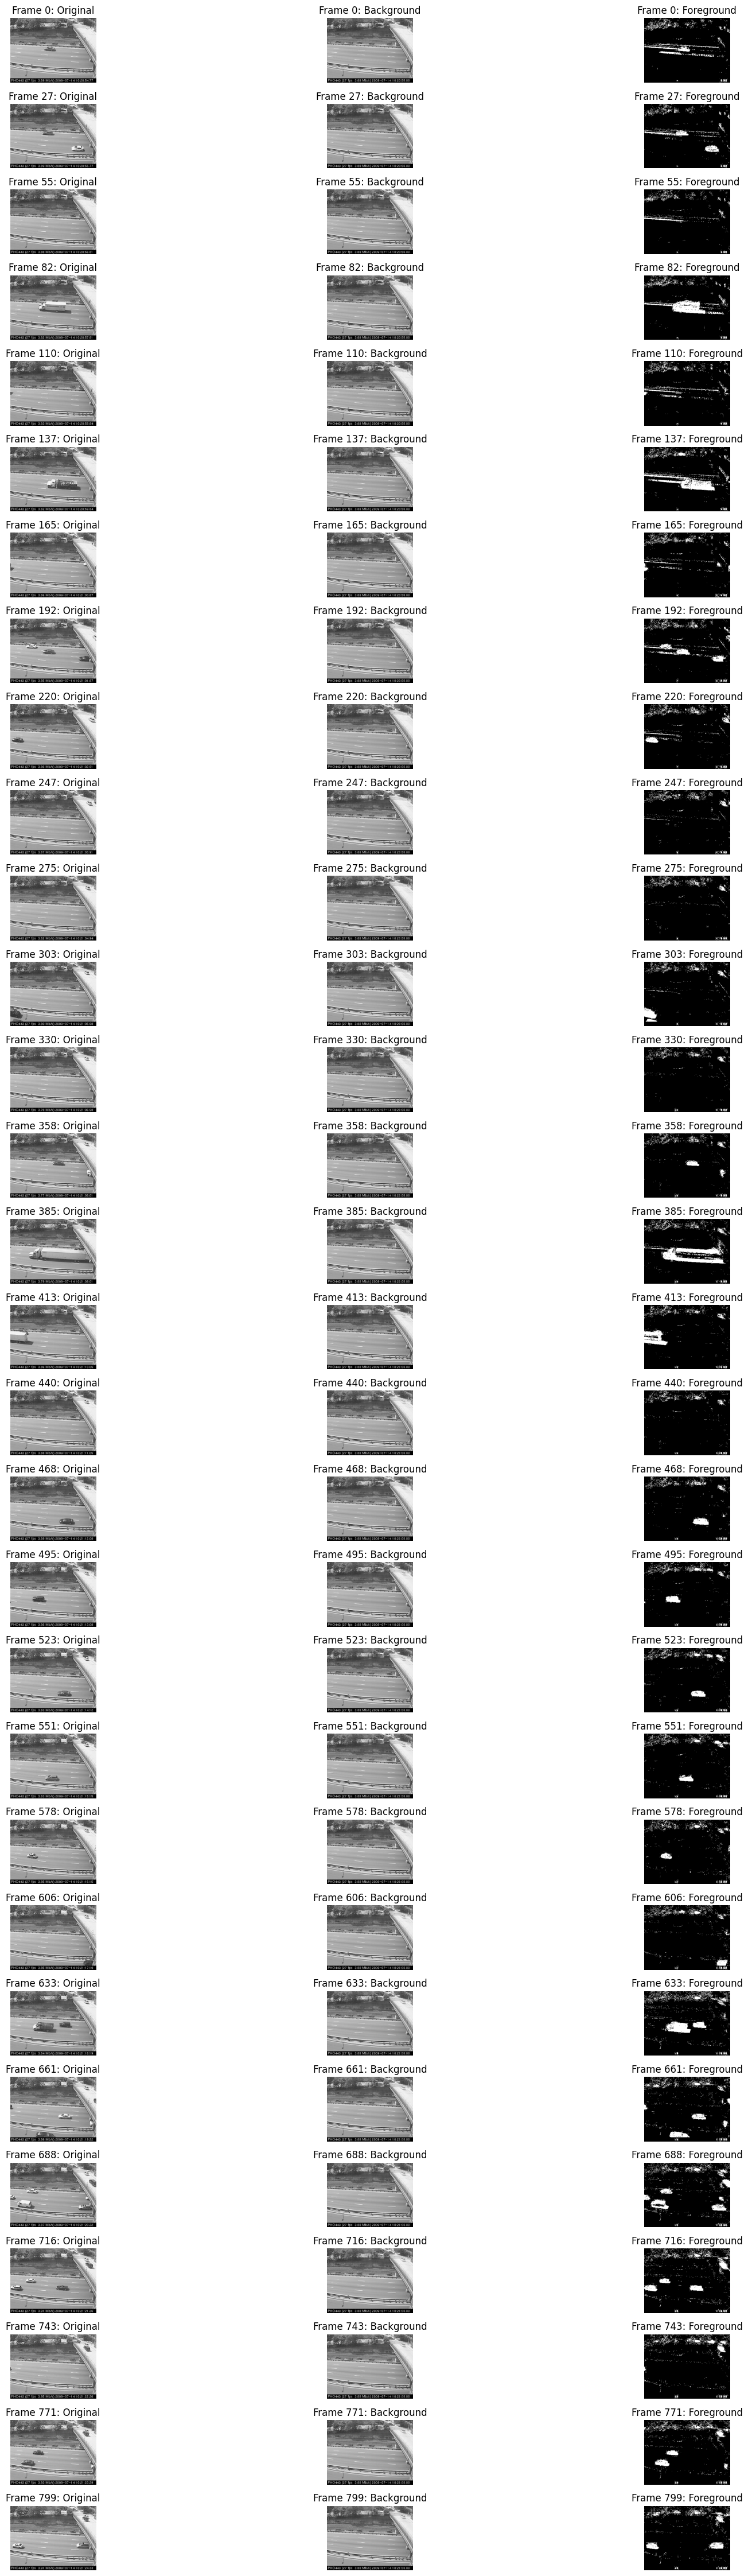

In [4]:
# Parameters
image_folder = "frames_folder"

# Process images
results = process_image_sequence(
        image_folder=image_folder,
        pattern="*.jpg",
        init_frames=100,
        max_frames=1600
)
    
# Display results for all frames
display_results_grid(results)